In [122]:
# %matplotlib notebook
%matplotlib inline

import copy
import numpy as np
import random
import matplotlib.pyplot as plt
import json
from collections import deque
from _converter_v2 import Event2Dict
from _evaluation import print_metrics

_true = "true"
_false = "false"
path = "../offline/"
"""
Quality_OK is mapped to Faultiness
    'False' -> 1 (Faulty)
    'True'  -> 0 (Good)
"""

"\nQuality_OK is mapped to Faultiness\n    'False' -> 1 (Faulty)\n    'True'  -> 0 (Good)\n"

In [92]:
def load(prod_id, mx=0):    
    with open(path+"layouts/"+prod_id+".json") as j:    
        layout = json.load(j)

    filename = prod_id+".txt"
    data = []
    times = []
    bad = 0
    
    print("Loading rows... {}".format(filename))
    with open(path+filename) as f:
        i = 0
        for line in f:
            i = i+1
            if mx>0 and i>mx:
                break
                
            try:
                features, timestamps = Event2Dict(json.loads(line), layout)
                data.append(features.values())
                times.append(timestamps.values())
            except Exception, e:
                print(e)
                break
                bad+=1

    print("Errors: {}".format(bad))
    print("Loaded: {}".format(len(data)))

    """ random split seed """
    data, times = np.asarray(data), np.asarray(times)
    # print(data.shape, times.shape)
    mask = np.random.rand(len(data)) < 0.9
    print("Total: {} Good: {} Faulty: {} Ratio: {}".format(len(data), len(data[data[:,-1]==_true]), len(data[data[:,-1]==_false]), len(data[data[:,-1]==_false])/float(len(data[data[:,-1]==_true]))))
    return data, times, mask

In [111]:
""" Logistic Sub-Sample """
from scipy.stats import logistic

# Take random numbers from a logistic probability density function
def logistic_choice(total, sample_size, replace=False):
    p = logistic.pdf(np.arange(0,total), loc=0, scale=total/5)
    p /= np.sum(p)
    return np.random.choice(total, size=sample_size, replace=replace, p=p)

def subsample(train, quiet=False):
    faulty = train[train[:,-1]==_false]
    not_faulty = train[train[:,-1]==_true]
    fr = len(faulty)/float(len(train))
    if not quiet:
        print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(not_faulty), len(faulty), fr))
        print("Test  Total: {} Good: {} Faulty: {} Ratio: {}".format(len(test), len(test[test[:,-1]==_true]), len(test[test[:,-1]==_false]), float(len(test[test[:,-1]==_false]))/len(test)))

        print("Re-sampling...")
        
    sample_size = np.min([5000, len(not_faulty)])
    samples = logistic_choice(len(not_faulty), sample_size)
    # TODO: Upsample faulties with logistic_choice(replace=True)
    f_sample_size = np.min([1000, len(faulty)])
    f_samples = logistic_choice(len(faulty), f_sample_size)
    # Put samples together and shuffle
    train = np.concatenate((not_faulty[samples], faulty[f_samples]))
    train = np.random.permutation(train)

    fr = len(train[train[:,-1]==_false])/float(len(train))
    if not quiet:
        print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(train[train[:,-1]==_true]), len(train[train[:,-1]==_false]), fr))

    return train

In [96]:
""" for single experiments """
data, _, mask = load("ABU4")
train = data[mask]
test = data[~mask]

test_data = test[:,2:-1].astype(np.float32)
test_labels = np.array(test[:,-1]==_false).astype(np.int32)
train_data = train[:,2:-1].astype(np.float32)
train_labels = np.array(train[:,-1]==_false).astype(np.int32)
# sub-sample
train_s = subsample(train)
train_data_s = train_s[:,2:-1].astype(np.float32)
train_labels_s = np.array(train_s[:,-1]==_false).astype(np.int32)

Loading rows... ABU4.txt
Errors: 0
Loaded: 32874
Total: 32874 Good: 31382 Faulty: 1492 Ratio: 0.0475431776177
Train Total: 29636 Good: 28300 Faulty: 1336 Ratio: 0.0450803077338
Test  Total: 3238 Good: 3082 Faulty: 156 Ratio: 0.0481778875849
Re-sampling...
Train Total: 6000 Good: 5000 Faulty: 1000 Ratio: 0.166666666667


In [97]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier

# ALL
clf = RandomForestClassifier(n_estimators=100, max_depth=90, n_jobs=4)
%time clf = clf.fit(train_data, train_labels)
# print_metrics(full_train_labels, clf.predict(full_train_data))
print_metrics(test_labels, clf.predict(test_data))

# SUBSAMPLE
clf = RandomForestClassifier(n_estimators=100, max_depth=90, n_jobs=4)
%time clf = clf.fit(train_data_s, train_labels_s)
# print_metrics(train_labels_s, clf.predict(train_data_s))
print_metrics(test_labels, clf.predict(test_data))

Wall time: 24.2 s
------------------------- EVALUATION -------------------------
Accuracy Score: 0.997838171711
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3082
          1       0.98      0.97      0.98       156

avg / total       1.00      1.00      1.00      3238

Confusion Matrix:
[[3079    3]
 [   4  152]]
Matthews Correlation Coefficient: 0.976362101135
--------------------------------------------------------------
Wall time: 3.5 s
------------------------- EVALUATION -------------------------
Accuracy Score: 0.994749845584
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3082
          1       0.92      0.97      0.95       156

avg / total       0.99      0.99      0.99      3238

Confusion Matrix:
[[3069   13]
 [   4  152]]
Matthews Correlation Coefficient: 0.944691904551
--------------------------------------------------------------


In [ ]:
""" Gradient Boosting """
from sklearn.ensemble import GradientBoostingClassifier
losses = ['deviance', 'exponential']

# ALL
clf = GradientBoostingClassifier(loss=losses[0], n_estimators=100,  max_depth=15, learning_rate=0.1)
%time clf = clf.fit(train_data, train_labels)
# print_metrics(full_train_labels, clf.predict(full_train_data))
print_metrics(test_labels, clf.predict(test_data))

# SUBSAMPLE
clf = GradientBoostingClassifier(loss=losses[0], n_estimators=100,  max_depth=25, learning_rate=0.1)
%time clf = clf.fit(train_data_s, train_labels_s)
# print_metrics(train_labels_s, clf.predict(train_data_s))
print_metrics(test_labels, clf.predict(test_data))

In [98]:
""" for group experiments """
# mx = 50000
# D = {}
# for n in range(1,6+1):
#     prod_id = "ABU{}".format(n)
#     data, _, mask = load(prod_id, mx)
#     D[prod_id] = {
#         'data': data, 
#         'mast': mask
#     }

data, _, mask = load("ABU4")
test = data[~mask]
test_data = test[:,2:-1].astype(np.float32)
test_labels = np.array(test[:,-1]==_false).astype(np.int32)

train = data[mask]
faulty = train[train[:,-1]==_false]
not_faulty = train[train[:,-1]==_true]



ratio = 0.95/0.05

Loading rows... ABU4.txt
Errors: 0
Loaded: 32874
Total: 32874 Good: 31382 Faulty: 1492 Ratio: 0.0475431776177
Train Total: 29609 Good: 28258 Faulty: 1351 Ratio: 0.0456280185079
Test  Total: 3265 Good: 3124 Faulty: 141 Ratio: 0.0431852986217
Re-sampling...
Train Total: 6000 Good: 5000 Faulty: 1000 Ratio: 0.166666666667


In [144]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=100, max_depth=90, n_jobs=4)
MCCs = []
HLs = []
print("Total\tMCC\tHL")
for tr in xrange(10,1720,100):
    small = np.concatenate((not_faulty[:int(tr*ratio)], faulty[:tr]))
    small_data = small[:,2:-1].astype(np.float32)
    small_labels = np.array(small[:,-1]==_false).astype(np.int32)
    clf = clf.fit(small_data, small_labels)
    predicted_labels = clf.predict(test_data)
    mcc = metrics.matthews_corrcoef(test_labels, predicted_labels)
    hl = metrics.hamming_loss(test_labels, predicted_labels)
    print("{}\t{}\t{}".format(len(small), mcc, hl))
    MCCs.append(mcc)
    HLs.append(hl)

# with sub-sample    
clf = RandomForestClassifier(n_estimators=100, max_depth=90, n_jobs=4)
MCCs_s = []
HLs_s = []
subs_size = []
print("Total\tMCC\tHL")
for tr in xrange(10,1720,100):
    small = np.concatenate((not_faulty[:int(tr*ratio)], faulty[:tr]))
    # sub-sample
    train_s = subsample(small, quiet=True)
    faulty_s = train_s[train_s[:,-1]==_false]
    not_faulty_s = train_s[train_s[:,-1]==_true]
    
    small = np.concatenate((not_faulty_s, faulty_s))
    subs_size.append(len(small))
    small_data = small[:,2:-1].astype(np.float32)
    small_labels = np.array(small[:,-1]==_false).astype(np.int32)
    clf = clf.fit(small_data, small_labels)
    predicted_labels = clf.predict(test_data)
    mcc = metrics.matthews_corrcoef(test_labels, predicted_labels)
    hl = metrics.hamming_loss(test_labels, predicted_labels)
    print("{}\t{}\t{}".format(len(small), mcc, hl))
    MCCs_s.append(mcc)
    HLs_s.append(hl)

Total	MCC	HL
199	0.0	0.0431852986217
2199	0.676046014796	0.0229709035222
4199	0.829646909762	0.0131699846861
6199	0.900926051839	0.00796324655436
8199	0.9471091452	0.00428790199081
10199	0.973852146214	0.00214395099541
12199	0.97005325485	0.00245022970904
14199	0.981413074288	0.00153139356815
16199	0.985101752332	0.00122511485452
18199	0.985101752332	0.00122511485452
20199	0.992587698986	0.000612557427259
22199	0.985101752332	0.00122511485452
24199	0.985101752332	0.00122511485452
26199	0.985101752332	0.00122511485452
28140	0.985101752332	0.00122511485452
29609	0.985101752332	0.00122511485452
29609	0.985101752332	0.00122511485452
29609	0.988850610411	0.000918836140888
Total	MCC	HL
199	0.0	0.0431852986217
2199	0.726830722298	0.0199081163859
4199	0.829192781473	0.0131699846861
5310	0.900926051839	0.00796324655436
5410	0.929350321433	0.00581929555896
5510	0.942106096516	0.00490045941807
5610	0.948908764814	0.00428790199081
5710	0.960484738687	0.00336906584992
5810	0.950424111368	0.00428790

In [115]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

clf = GradientBoostingClassifier(loss='deviance', n_estimators=100,  max_depth=15, learning_rate=0.1)
GBMCCs = []
GBHLs = []
print("Total\tMCC\tHL")
for tr in xrange(10,1720,100):
    small = np.concatenate((not_faulty[:int(tr*ratio)], faulty[:tr]))
    small_data = small[:,2:-1].astype(np.float32)
    small_labels = np.array(small[:,-1]==_false).astype(np.int32)
    clf = clf.fit(small_data, small_labels)
    predicted_labels = clf.predict(test_data)
    mcc = metrics.matthews_corrcoef(test_labels, predicted_labels)
    hl = metrics.hamming_loss(test_labels, predicted_labels)
    print("{}\t{}\t{}".format(len(small), mcc, hl))
    GBMCCs.append(mcc)
    GBHLs.append(hl)
    
# with sub-sample
clf = GradientBoostingClassifier(loss='deviance', n_estimators=100,  max_depth=25, learning_rate=0.1)
GBMCCs_s = []
GBHLs_s = []
print("Total\tMCC\tHL")
for tr in xrange(10,1720,100):
    small = np.concatenate((not_faulty[:int(tr*ratio)], faulty[:tr]))
    # sub-sample
    train_s = subsample(small, quiet=True)
    faulty_s = train_s[train_s[:,-1]==_false]
    not_faulty_s = train_s[train_s[:,-1]==_true]
    
    small = np.concatenate((not_faulty_s, faulty_s))
    small_data = small[:,2:-1].astype(np.float32)
    small_labels = np.array(small[:,-1]==_false).astype(np.int32)
    clf = clf.fit(small_data, small_labels)
    predicted_labels = clf.predict(test_data)
    mcc = metrics.matthews_corrcoef(test_labels, predicted_labels)
    hl = metrics.hamming_loss(test_labels, predicted_labels)
    print("{}\t{}\t{}".format(len(small), mcc, hl))
    GBMCCs_s.append(mcc)
    GBHLs_s.append(hl)

Total	MCC	HL
199	0.12073445605	0.054517611026
2199	0.764074544391	0.0177641653905
4199	0.838300993625	0.0125574272588
6199	0.900926051839	0.00796324655436
8199	0.962538333133	0.00306278713629
10199	0.973852146214	0.00214395099541
12199	0.966363304819	0.00275650842266
14199	0.973975538166	0.00214395099541
16199	0.97005325485	0.00245022970904
18199	0.973783176925	0.00214395099541
20199	0.985101752332	0.00122511485452
22199	0.977568176567	0.00183767228178
24199	0.988850610411	0.000918836140888
26199	0.992587698986	0.000612557427259
28140	0.985101752332	0.00122511485452
29609	0.981413074288	0.00153139356815
29609	0.97005325485	0.00245022970904
29609	0.973852146214	0.00214395099541
Total	MCC	HL
199	0.104970484058	0.0563552833078
2199	0.775983865113	0.0168453292496
4199	0.827019606404	0.0134762633997
5310	0.898370235417	0.00826952526799
5410	0.951662929799	0.00398162327718
5510	0.956222796182	0.00367534456355
5610	0.950424111368	0.00428790199081
5710	0.961439166339	0.00336906584992
5810	0.92

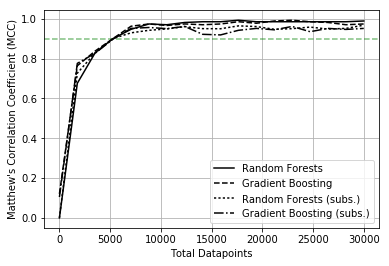

In [198]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', quality=100)

rrange = xrange(0,30000,int(np.ceil(30000/17)))
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.set_ylabel('Matthew\'s Correlation Coefficient (MCC)')


ax1.set_xlabel("Total Datapoints")
p = ax1.plot(rrange, MCCs, label="Random Forests", color="black")
ax1.axhline(y=0.9, color='g', linestyle='dashed', alpha=.5)
ax1.grid(True)
ax1.legend(loc=4)
# for xy in zip(rrange, MCCs):  
#     ax1.annotate("%.2f"%xy[1], xy=xy, textcoords='data')

ax3 = fig.add_subplot(111)
ax3.plot(rrange, GBMCCs, label="Gradient Boosting", color="black", linestyle='--')
ax3.legend(loc=4)

ax5 = fig.add_subplot(111)
ax5.plot(rrange, MCCs_s, label="Random Forests (subs.)", color="black", linestyle=':')
ax5.legend(loc=4)

ax5 = fig.add_subplot(111)
ax5.plot(rrange, GBMCCs_s, label="Gradient Boosting (subs.)", color="black", linestyle='-.')
ax5.legend(loc=4)

# ax2 = ax1.twiny()
# ax2.cla()
# ax2.set_xlabel('Sub-sample Datapoints')
# ax2.plot(subs_size,np.ones(18), alpha=.0)
# print subs_size

plt.show()

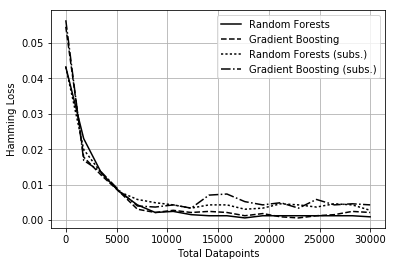

In [199]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', quality=100)

rrange = xrange(0,30000,int(np.ceil(30000/17)))
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.set_ylabel('Hamming Loss')


ax1.set_xlabel("Total Datapoints")
p = ax1.plot(rrange, HLs, label="Random Forests", color="black")
# ax1.axhline(y=0.9, color='g', linestyle='dashed', alpha=.5)
ax1.grid(True)
ax1.legend(loc=1)
# ax1.set_autoscaley_on(False)
# ax1.set_ylim([0.0,0.06])

ax3 = fig.add_subplot(111)
ax3.plot(rrange, GBHLs, label="Gradient Boosting", color="black", linestyle='--')
ax3.legend(loc=1)

ax5 = fig.add_subplot(111)
ax5.plot(rrange, HLs_s, label="Random Forests (subs.)", color="black", linestyle=':')
ax5.legend(loc=1)

ax5 = fig.add_subplot(111)
ax5.plot(rrange, GBHLs_s, label="Gradient Boosting (subs.)", color="black", linestyle='-.')
ax5.legend(loc=1)

plt.show()

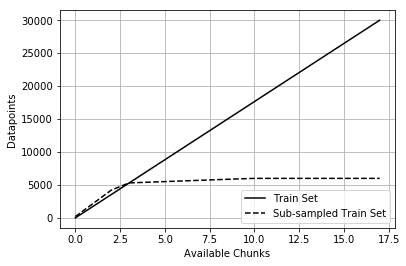

In [200]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', quality=100)

rrange = xrange(0,30000,int(np.ceil(30000/17)))
arange = xrange(0,18,1)
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.set_ylabel('Datapoints')
ax1.set_xlabel('Available Chunks')
p = ax1.plot(arange, rrange, label="Train Set", color="black")
ax1.grid(True)
ax1.legend(loc=4)

ax3 = fig.add_subplot(111)
ax3.plot(arange, subs_size, label="Sub-sampled Train Set", color="black", linestyle='--')
ax3.legend(loc=4)

plt.show()